# Partie 1. - Découverte du jeu de données et lecture des documents

Dans cette partie, nous allons travailler sur un jeu de données que nous pourrions avoir en entreprise. 

Ce jeu de données contient un ensemble de documents PDF (majoritaires), word et PowerPoint dont certains sont des documents scannés.

L'objectif de cette partie est de construire un programme informatique permettant, automatiquement, d'ouvrir les documents et d'en extraire les contenus. Pour les documents scannés ou les images, nous utilisons la technique d'OCR (Object Character Recognition) pour extraire le texte des images.

Les bibliothèques que nous allons utiliser sont les suivantes :
- **Apache Tika** (https://tika.apache.org/) : lecture d'un grand nombre de format de documents et extraction du contenu et des métadonnées
- **Tesseract** (https://github.com/tesseract-ocr/tesseract) : moteur de reconnaissance optique de caractères (OCR)

## Import des bibliothèques logicielles et configuration

In [40]:
from tika import parser # Bibliothèque Tika pour la lecture des documents

# Autres bibliothèques utilitaires pour le TP
import os, glob, random, tabulate
from IPython.display import Image
from  IPython.core.display import display, HTML



In [42]:
DATASET_DIRECTORY = "./dataset" # indique le répertoire de base où se trouve les document à indexer
USE_OCR = True # indique si l'OCR doit être activé ou non (ralenti le processus)

## 1. Lecture des documents et extraction du texte

Dans cette section, nous allons parcourir l'ensemble des documents du dataset puis pour chacun d'entre eux, nous allons extraire :
- son titre (nom de fichier)
- son contenu ;
- son chemin sur le système de fichiers.

Le bloc de code ci-dessous est une fonction permettant de parcourir l'ensemble des fichiers présent dans un dossier et retourne les chemins de ces derniers.

Exécuter le bloc de code ci-dessous pour charger cette fonction afin de l'utiliser par la suite.

In [48]:
def get_all_files_in_directory(directory):
    """Fonction retournant l'ensemble des chemins des fichiers se trouvant dans le répertoire directory."""
    file_paths = set()
    for filename in glob.iglob(directory + '/**', recursive=True):
        if os.path.isfile(filename): 
            file_paths.add(filename)
    return file_paths

def read_files_and_extract_content(input_file_paths):
    """
    Fonction qui permet de lire l'ensemble des fichiers dont les chemins sont spécifiés en paramètre.
    Retourne un dictionnaire contenant les documents extraits. 
    Pour chaque document 4 champs sont récupérés ou calculés : title, path, content, file_size.
    """
    documents = {}
    for input_file_path in input_file_paths:
        parsed_file = parser.from_file(input_file_path)
        title = os.path.basename(input_file_path)
        content = parsed_file['content']
        if(content is None):
            content = "" 
        file_size = os.path.getsize(input_file_path)
        document = {"title": title, "path":input_file_path, "content":content, "file_size": file_size}
        documents[input_file_path] = document
    return documents

Exécuter le bloc de code ci-dessous pour charger un échantillon de 5 chemins de fichiers. Nous chargerons l'ensemble de données complet à la fin de cette partie.

In [50]:
input_file_paths = get_all_files_in_directory(DATASET_DIRECTORY) # Appel de la fonction et récupération des chemins des fichiers.
input_file_paths_sample = random.sample(input_file_paths, 5)
print("Exemple aléatoires de chemins de fichiers.")
for input_file_path in input_file_paths_sample:
    print("\t" + input_file_path) # Tips : \t permet d'ajouter une tabulation.

Exemple aléatoires de chemins de fichiers.
	./dataset/data-gouv-pdf-txt/data_gouv_txt/Region_Hauts-de-France/5e6c230606e3e7307f7168d6--f4e660f9-e602-48f5-ac85-344a77933fc0.txt
	./dataset/data-gouv-pdf-txt/data_gouv_txt/Region_Hauts-de-France/5e6c23059ce2e738d6f4c8b5--4acce878-32d8-49e4-91e9-e7d7b7d39b7e.txt
	./dataset/data-gouv-pdf-txt/data_gouv_txt/Ville_de_Pirae/5859c9a788ee3824b3609f67--3fdafc63-8f57-40ca-8e5d-7717ac847825.txt
	./dataset/data-gouv-pdf-txt/data_gouv_txt/Ministere_des_Solidarites_et_de_la_Sante/555ef055c751df4bdfc98e0f--e6ed346b-87a7-440c-bdfb-98fc6b515a24.txt
	./dataset/data-gouv-pdf-txt/data_gouv_txt/Ville_de_Pirae/586c59dfc751df5ad12b7154--a20191a8-96f1-4d13-8c90-81b30924a4ce.txt


Exécuter le bloc de code ci-dessous pour lire l'ensemble des fichiers à partir d'une liste de chemin de fichiers.

In [52]:
documents = read_files_and_extract_content(input_file_paths)

A ce bloc, les documents ont été lus et leurs contenus a été placé dans le dictionnaire `documents` dont la clef est un chemin sur le système de fichier et la valeur le document extrait. 

### 2. Reconnaissance Optique de Caractères

La reconnaissance optique de caractères (Object Character Recognition - OCR) permet d'extraire du texte à partir d'une image, par exemple un document scanné. 

Cette tâche, simple pour l'humain, l'est moins pour la machine qui ne "voit" que des pixels, parfois bruités avec des tailles de polices différentes. Les algorithmes mis en jeu pour cette tâche procèdent généralement de la façon suivante :
- **Pré-traitement de l'image** pour la normaliser, la débruiter, accentuer les contours de formes, ...
- **Détection des lignes, des mots et des caractères** : seln la qualité de l'image, le texte n'est pas toujours positionnné de manière parfaitement horizontale et les mots et les lignes ne sont pas toujours clairement séparés.
- **Reconnaissance de caractères** : le procédé peut mettre en jeu plusieurs algorithmes, par exemple pour déterminer le mot le plus probable en fonction du contexte. C'est particulièrement utile lorsque les caractères sont semblables, comme 0 (zéro) et O (lettre).
- **Production du texte de sortie.**

Pour réaliser cette tâche, nous pouvons utiliser la célèbre bibliothèque open-source _Tesseract_, aujourd'hui maintenue par Google (https://github.com/tesseract-ocr/tesseract). Tesseract est nativement intégré à Tika qui l'utilise pour extraire du texte lorsque le fichier est un image ou en contient une (dans un PDF par exemple).

L'OCR requiert de la puissance de calcul et peut ralentir les traitements. Aussi, dans le cadre de ce TP, nous n'exploitons que quelques fichiers qui sont des images.

Ci-dessous, nous visualisons une image et le résultat obtenu après OCR.

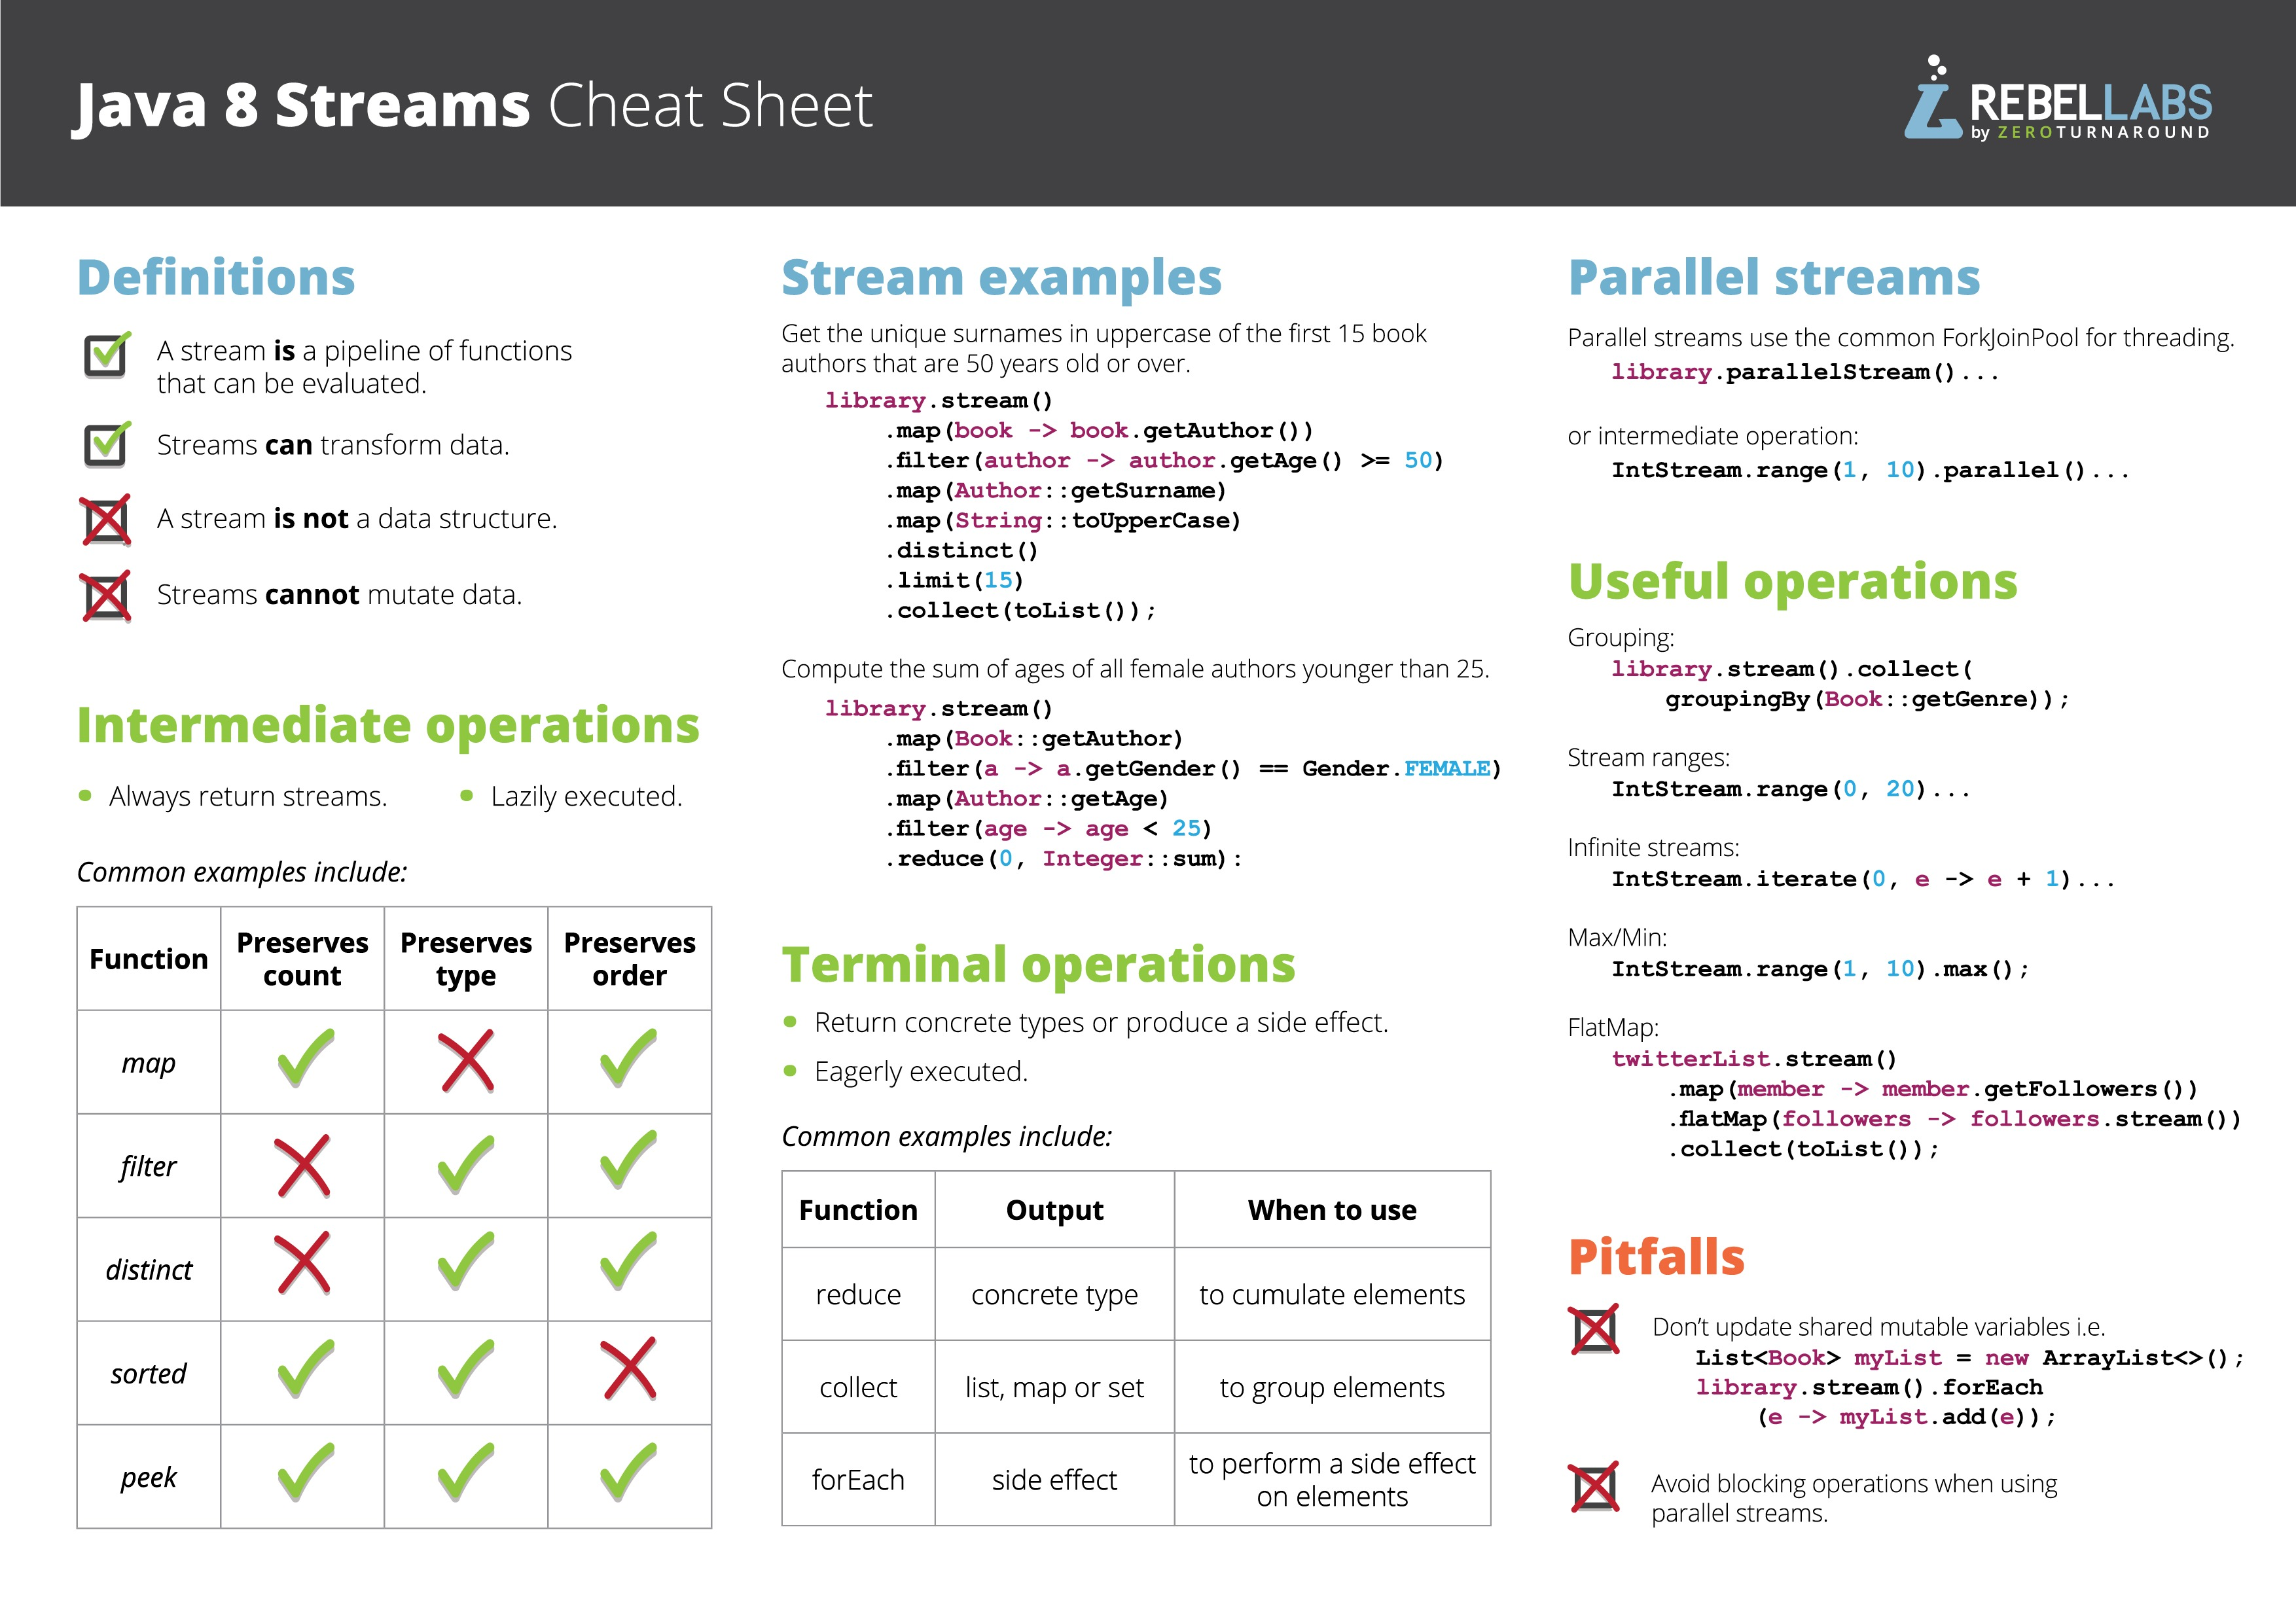

In [51]:
img = Image(filename='./dataset/images/Java-8-Streams-cheat-sheet-v3.jpg', height=450) 
content = "".join([s for s in documents['./dataset/images/Java-8-Streams-cheat-sheet-v3.jpg']["content"].splitlines(True) if s.strip("\r\n")]) 

display(img)
display(HTML("<h3> Résultat de l'extraction (extraction) </h3>" + content[0:230].replace("\n", "<br/>")))

**Analyse**

Nous constatons que le texte est bien reconnu, hormis quelques pictogrammes comme les symboles "Validé" ou "Invalidés" qui ne sont pas des caractères de l'alphabet. 

Selon la qualité du document, certains caractères peuvent être mal reconnus ; mais selon les tâches, cela peut être acceptable. Si l'on recherche une information.

### 3. Affichage de statistiques sur le jeu de données

**Exercice**

Maintenant que nous avons lu et chargé le jeu de données, nous pouvons afficher quelques statistiques.

In [53]:
doc_count = len(documents) # TODO
size_on_disk_mo = sum([doc['file_size'] for doc in documents.values()]) / 1000000
average_document_size_ko = size_on_disk_mo / doc_count * 1000
average_chars_per_document = sum([len(doc['content']) for doc in documents.values()]) / doc_count

print("Nombre de documents: {}".format(doc_count))
print("Poids sur disque du jeu de données en Mo: {} Mo".format(size_on_disk_mo))
print("Poids moyen d'un document en Ko: {} Ko".format(average_document_size_ko))
print("Nombre moyen de caractères par document: {}".format(average_chars_per_document))


Nombre de documents: 6602
Poids sur disque du jeu de données en Mo: 320.766636 Mo
Poids moyen d'un document en Ko: 48.58628233868525 Ko
Nombre moyen de caractères par document: 46410.81611632839


### 4. Sauvegarde
L'étape de parcours des documents et d'extraction du texte, éventuellement avec l'OCR, peut être très longue.
Aussi, nous allons sauvegarder le résultat de l'extraction au format JSON sur le disque afin de le réutiliser dans la suite du TP.

**Attention** : le fichier produit pèse plusieurs centaine de Mo. L'ouvrir avec un éditeur de texte risque de faire planter la machine.

In [38]:
f = open("./dataset_processed/dataset.json", "w")
f.write(str(documents))
f.close()

## Conclusion

Dans cette partie, nous avons vu comment lire et extraire le texte de documents bureautiques. D'autres techniques et bibliothèques existent pour extraire de l'information d'autres sources de données (base de données, pages web, ...). Cela n'est pas encore du TALN mais cette étape est nécessaire pour ensuite pouvoir traiter et analyser sereinement les données. 